In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from experiments2.auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt.networks.continuous_bn import ContinuousBN
from bamt.networks.hybrid_bn import HybridBN
from bamt_inherited.networks.discrete import DiscreteBNGI

from tqdm import tqdm
imagespath = 'error_gradation_images'

In [2]:
data = pd.read_csv("../../datasets/abalone.data", sep=',',
                   names=['sex', 'length', 'diameter', 'height', 'W_weight', 'S_weight', 'viscera_weight',
                          'shell_weight', 'rings'])
data = data[data["sex"] != "I"]
data["sex"] = data["sex"].replace({"F": 1, "M": 0})
data = data.reset_index().drop(columns=["index"])
n_features = data.shape[1] - 1
n = data.shape[0]
target = "sex"
features = data.columns.difference([target]).tolist()

data.head(10)

,sex,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,1,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
5,1,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
6,0,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
7,1,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19
8,1,0.525,0.380,0.140,0.6065,0.1940,0.1475,0.210,14
9,0,0.430,0.350,0.110,0.4060,0.1675,0.0810,0.135,10


In [3]:
def entropy(a):
    vc = a.value_counts()
    vc /= vc.sum()
    return -(vc * np.log(vc)).sum()


def discretize(data, variables, icat, icont, contdiscstrategy="kmeans", n_bins=3):
    transformers_data = dict()

    if icat is None:  # в датасете только непрерывные фичи (и предиктор)
        pipeline = make_pipeline(
            KBinsDiscretizer(n_bins=n_bins, encode="ordinal", random_state=42, strategy=contdiscstrategy),
            FunctionTransformer(lambda x: x.astype("int")))
    elif icont is None:  # в датасете только категориальные фичи (и предиктор)
        pipeline = make_pipeline(
            OrdinalEncoder(categories="auto"),
            FunctionTransformer(lambda x: x.astype("int")))
    else:
        pipeline = make_pipeline(make_union(
            make_pipeline(FunctionTransformer(lambda x: x.iloc[:, icat]), OrdinalEncoder(categories="auto")),
            make_pipeline(FunctionTransformer(lambda x: x.iloc[:, icont]),
                          KBinsDiscretizer(n_bins=n_bins, encode="ordinal", random_state=42, strategy=contdiscstrategy))
        ),
            FunctionTransformer(lambda x: x.astype("int")))
        

    pipeline.fit(data)
    encoded_data = pd.DataFrame(pipeline.transform(data), columns=data.columns if icat is None or icont is None \
        else data.columns[icat + icont])
    encoded_data = encoded_data[
        variables]  # в общем случае пайплайн переставляет признаки, возвращаем их на их места здесь

    for feat in encoded_data.columns:
        if entropy(encoded_data[feat]) < 0.5:
            print(f"Warning: feature {feat} has practically degenerate states and low entropy")
    transformers_data["transformer"] = pipeline

    if icat is None:
        transformers_data["cont_features"] = list(pipeline.steps[0][1].get_feature_names_out())
        transformers_data["cont_features_edges"] = pipeline.steps[0][1].bin_edges_

    elif icont is None:
        transformers_data["cat_features"] = list(pipeline.steps[0][1].get_feature_names_out())
        transformers_data["cat_features_categories"] = pipeline.steps[0][1].categories_

    else:
        transformers_data["cont_features"] = list(
            pipeline.steps[0][1].named_transformers["pipeline-2"].steps[1][1].get_feature_names_out())
        transformers_data["cont_features_edges"] = pipeline.steps[0][1].named_transformers["pipeline-2"].steps[1][
            1].bin_edges_
        transformers_data["cat_features"] = list(
            pipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].get_feature_names_out())
        transformers_data["cat_features_categories"] = pipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][
            1].categories_

    #kmeanspipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].categories_[0]
    return encoded_data, transformers_data

In [4]:
#data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))
data = data[data["height"] < 0.26]
data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))

In [5]:
model = GradientBoostingClassifier(n_estimators=50)
#model = LogisticRegression()
model.fit(data[features], data[target])
data_errors = data.copy(deep=True)
probs = model.predict_proba(data[features])[:, 1]
data_errors["inconf_error"] = (1 - probs) * data[target] + (probs) * (
            1 - data[target])  #inconfidence measure: the larger the worser inconfidence
#data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,sex,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings,inconf_error
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0.265942
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0.269746
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0.545291
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0.472735
4,1,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20,0.536918


In [6]:
disc_data, pipeline_data = discretize(data_errors, features + ["inconf_error", target], icat=[0],
                                      icont=list(range(1, n_features + 2)))

In [7]:
current_error = data_errors["inconf_error"].sum() / n
current_error

0.4614116561413063

In [8]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore


def collect_all_cpds(bn_info, distributions, n_states_map):
    cpds = list()
    for index, row in bn_info.iterrows():
        feat = row["name"].name
        if len(row["parents"]) == 0:
            # cpd is just a pd
            cpd = TabularCPD(feat, n_states_map[feat], [[e] for e in distributions[feat]["cprob"]])
            cpds.append(cpd)
        else:
            cpd_list = [probs for probs in distributions[feat]["cprob"].values()]
            #cpd_list = [probs for i, probs in distributions[feat]["cprob"].items() if i[0]!="["]
            #print(cpd_list)
            nrows = len(cpd_list)
            ncols = len(cpd_list[0])
            cpd_list = [[cpd_list[i][j] for i in range(nrows)] for j in range(ncols)]
            #print(feat, row["parents"])
            #print(cpd_list)
            cpd = TabularCPD(feat, n_states_map[feat], cpd_list, evidence=row["parents"],
                             evidence_card=[n_states_map[p] for p in row["parents"]])
            cpds.append(cpd)
    return cpds



In [9]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'sex': 2,
 'length': 3,
 'diameter': 3,
 'height': 3,
 'W_weight': 3,
 'S_weight': 3,
 'viscera_weight': 3,
 'shell_weight': 3,
 'rings': 3,
 'inconf_error': 3}

In [10]:
#from bamt.networks.base import STORAGE

ImportError: cannot import name 'STORAGE' from 'bamt.networks.base' (C:\Users\User\PycharmProjects\GIEBN\venv\lib\site-packages\bamt\networks\base.py)

In [11]:
#STORAGE = "C://Users/Дима/PycharmProjects/GIEBN/experiments/pgmpy_yodo_exps/bn_structures"

bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

#blacklist = [("ent_error", x) for x in features]
#bn.add_edges(disc_data, scoring_function=("K2", K2Score))
#bn.fit_parameters(data=disc_data)

In [11]:
bn.add_edges(disc_data, scoring_function=("K2", BicScore))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [12]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,S_weight,Discrete,disc,[],[]
1,W_weight,Discrete,disc,[S_weight],[disc]
2,height,Discrete,disc,[W_weight],[disc]
3,inconf_error,Discrete,disc,"[W_weight, height]","[disc, disc]"
4,diameter,Discrete,disc,"[W_weight, height]","[disc, disc]"
5,length,Discrete,disc,"[S_weight, diameter]","[disc, disc]"
6,shell_weight,Discrete,disc,"[W_weight, diameter]","[disc, disc]"
7,viscera_weight,Discrete,disc,"[W_weight, length]","[disc, disc]"
8,rings,Discrete,disc,"[S_weight, shell_weight]","[disc, disc]"
9,sex,Discrete,disc,"[shell_weight, viscera_weight, inconf_error]","[disc, disc, disc]"


In [13]:
bn.nodes

[S_weight,
 W_weight,
 height,
 inconf_error,
 diameter,
 length,
 shell_weight,
 viscera_weight,
 rings,
 sex]

In [14]:
bn.fit_parameters(data=disc_data, n_jobs=1)

In [15]:
bn.distributions

{'S_weight': {'cprob': [0.3727497352629721,
   0.4712319096364278,
   0.15601835510060008],
  'vals': ['0', '1', '2']},
 'W_weight': {'cprob': {"['0']": [0.8229166666666666,
    0.17708333333333334,
    0.0],
   "['1']": [0.026217228464419477, 0.8741573033707866, 0.099625468164794],
   "['2']": [0.0, 0.13574660633484162, 0.8642533936651584]},
  'vals': ['0', '1', '2']},
 'height': {'cprob': {"['0']": [0.4502212389380531,
    0.5287610619469026,
    0.02101769911504425],
   "['1']": [0.02050919377652051, 0.6414427157001414, 0.33804809052333806],
   "['2']": [0.0, 0.0970873786407767, 0.9029126213592233]},
  'vals': ['0', '1', '2']},
 'inconf_error': {'cprob': {"['0', '0']": [0.3808353808353808,
    0.29238329238329236,
    0.32678132678132676],
   "['0', '1']": [0.04184100418410042, 0.5, 0.4581589958158996],
   "['0', '2']": [0.10526315789473684, 0.5263157894736842, 0.3684210526315789],
   "['1', '0']": [0.13793103448275862,
    0.5862068965517241,
    0.27586206896551724],
   "['1', '1'

In [16]:
np.random.seed(42)
he_data = bn.sample(n=5000, evidence={"inconf_error": 2})
le_data = bn.sample(n=5000, evidence={"inconf_error": 0})

100%|██████████| 5000/5000 [00:00<00:00, 9835.51it/s] 


In [13]:
cbn = HybridBN(use_mixture=True)
nodes_data = {"types": {feat: "cont" for feat in data_errors.columns},
               "signs": {feat: "pos" for feat in data_errors.columns}}

nodes_data["types"][target] = "disc"

cbn.add_nodes(nodes_data)

blacklist = [(x, "inconf_error") for x in features]
#bn.add_edges(disc_data, scoring_function=("K2", K2Score))
#bn.fit_parameters(data=disc_data)
cbn.add_edges(disc_data, scoring_function=("K2", K2Score), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [14]:
cbn.fit_parameters(data_errors)

In [15]:
cbn.get_info()

,name,node_type,data_type,parents,parents_types
0,sex,Discrete,disc,[],[]
1,inconf_error,ConditionalMixtureGaussian,cont,[sex],[disc]
2,diameter,ConditionalMixtureGaussian,cont,"[inconf_error, sex]","[cont, disc]"
3,W_weight,ConditionalMixtureGaussian,cont,"[diameter, inconf_error, sex]","[cont, cont, disc]"
4,shell_weight,MixtureGaussian,cont,"[W_weight, diameter]","[cont, cont]"
5,S_weight,ConditionalMixtureGaussian,cont,"[W_weight, diameter, inconf_error, sex]","[cont, cont, cont, disc]"
6,length,MixtureGaussian,cont,"[S_weight, diameter, shell_weight]","[cont, cont, cont]"
7,height,MixtureGaussian,cont,"[W_weight, length, shell_weight]","[cont, cont, cont]"
8,viscera_weight,MixtureGaussian,cont,"[S_weight, W_weight, length]","[cont, cont, cont]"
9,rings,MixtureGaussian,cont,"[S_weight, height, shell_weight]","[cont, cont, cont]"


In [20]:
cbn.sample(5, evidence={"inconf_error": 0.1})

100%|██████████| 5/5 [00:00<00:00, 28.36it/s]


,sex,inconf_error,diameter,S_weight,W_weight,shell_weight,length,height,viscera_weight,rings
0,0,0.1,0.201857,0.039202,0.097552,0.031975,0.284019,0.079089,0.019800,5.209502
1,1,0.1,0.788045,1.196733,3.050205,0.777105,0.871291,0.235159,0.521730,13.162885
2,1,0.1,0.753303,1.010839,2.491846,0.695605,0.840479,0.183508,0.535377,23.412489
3,0,0.1,0.168720,0.032279,0.071939,0.024446,0.235992,0.063077,0.017664,5.837550
4,1,0.1,0.784098,1.288533,2.964497,0.849248,0.959558,0.273826,0.719005,20.127913


In [21]:
le_data = cbn.sample(1000, evidence={"inconf_error": 0.1})[data_errors.columns]
le_data[target] = le_data[target].astype(int)
le_data_disc=pd.DataFrame(pipeline_data["transformer"].transform(le_data), columns=data_errors.columns)

100%|██████████| 1000/1000 [00:22<00:00, 44.29it/s]


In [22]:
le_data

,sex,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings,inconf_error
0,1,0.541014,0.424369,0.137281,0.638325,0.239911,0.156977,0.197110,12.619700,0.1
1,0,0.249669,0.191206,0.068693,0.071049,0.028497,0.011766,0.024346,6.399385,0.1
2,0,0.344923,0.229438,0.082068,0.144241,0.046377,0.032967,0.051833,9.206399,0.1
3,1,0.541443,0.459050,0.147387,0.931877,0.227686,0.212218,0.253346,10.745821,0.1
4,0,0.221541,0.159180,0.048199,0.059318,0.023930,0.009543,0.021255,6.864320,0.1
...,...,...,...,...,...,...,...,...,...,...
983,0,0.244348,0.181755,0.065680,0.069667,0.030547,0.016479,0.024466,4.561065,0.1
984,0,0.240305,0.166993,0.059507,0.082784,0.036436,0.022695,0.024489,4.236209,0.1
985,0,0.706526,0.547937,0.190581,1.963427,1.104560,0.551609,0.499419,11.518202,0.1
986,1,0.831190,0.701032,0.222376,2.785813,1.126961,0.614326,0.697923,11.808579,0.1


In [23]:
he_data = cbn.sample(1000, evidence={"inconf_error": 0.7})[data_errors.columns]
he_data[target] = he_data[target].astype(int)
he_data_disc=pd.DataFrame(pipeline_data["transformer"].transform(he_data), columns=data_errors.columns)

100%|██████████| 1000/1000 [00:21<00:00, 47.17it/s]


In [24]:
pipeline_data["cont_features_edges"]

array([array([0.155     , 0.44954847, 0.58467305, 0.815     ]),
       array([0.11      , 0.34764813, 0.45874423, 0.65      ]),
       array([0.015     , 0.12483516, 0.16729445, 0.25      ]),
       array([0.0155    , 0.80401623, 1.39389237, 2.8255    ]),
       array([0.0065    , 0.36053488, 0.63703591, 1.488     ]),
       array([0.003     , 0.18343269, 0.31478578, 0.76      ]),
       array([0.005     , 0.2316796 , 0.39992087, 1.005     ]),
       array([ 3.        , 11.32401625, 16.20766396, 29.        ]),
       array([0.08965033, 0.34566726, 0.48768821, 0.89358208])],
      dtype=object)

In [25]:
data["height"].max()

0.25

In [58]:
disc_data["inconf_error"].value_counts()

inconf_error
1    1379
2    1113
0     341
Name: count, dtype: int64

In [27]:
pipeline_data["cont_features"] == "diameter"

False

<Figure size 640x480 with 0 Axes>

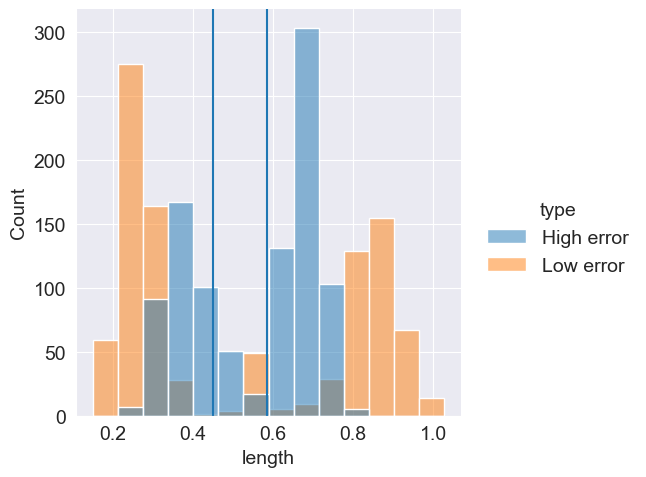

<Figure size 640x480 with 0 Axes>

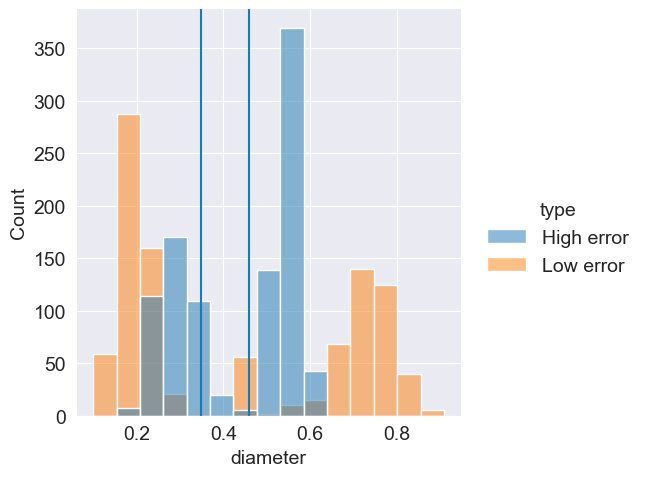

<Figure size 640x480 with 0 Axes>

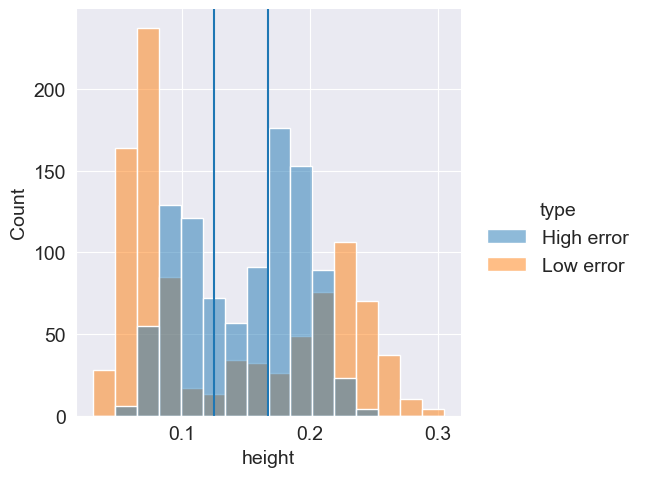

<Figure size 640x480 with 0 Axes>

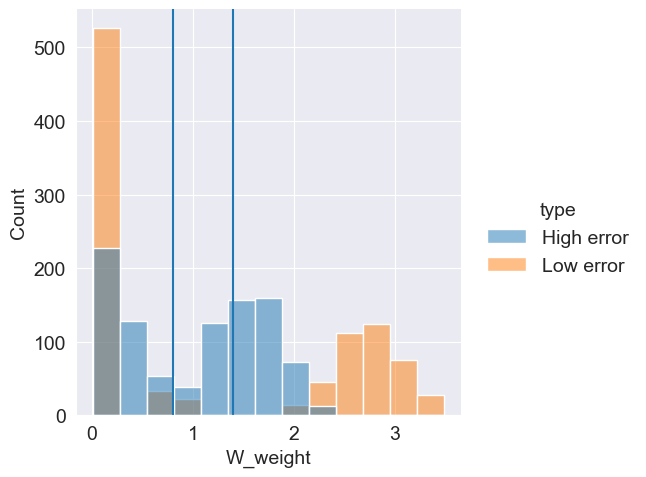

<Figure size 640x480 with 0 Axes>

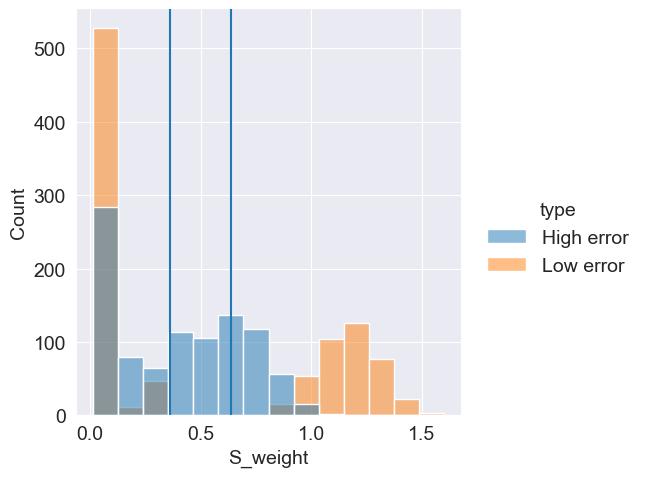

<Figure size 640x480 with 0 Axes>

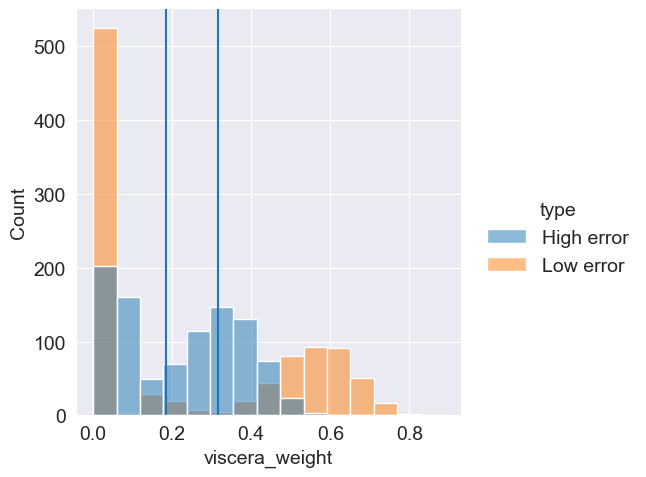

<Figure size 640x480 with 0 Axes>

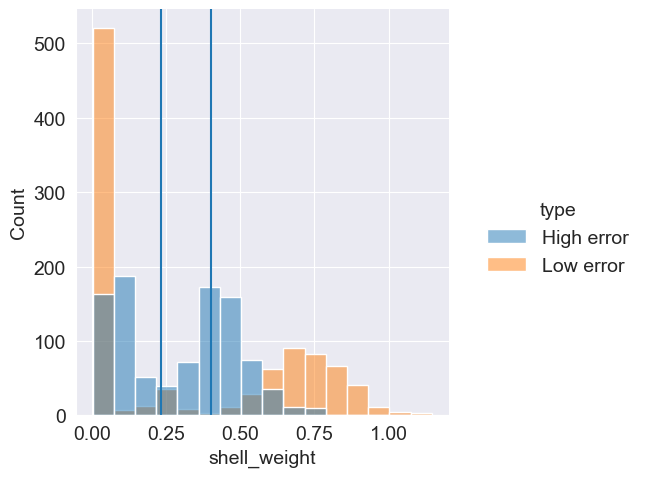

<Figure size 640x480 with 0 Axes>

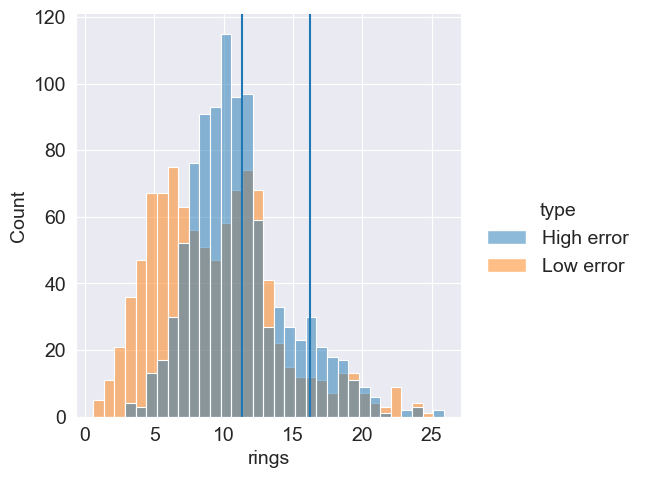

<Figure size 640x480 with 0 Axes>

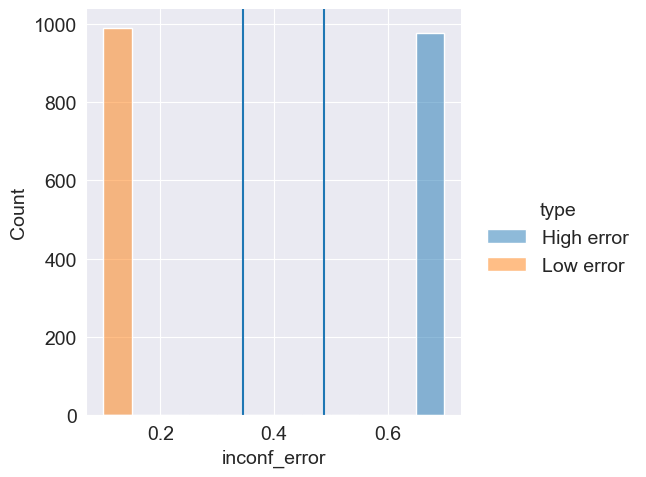

In [28]:
he_data["type"] = "High error"
le_data["type"] = "Low error"
all_data = pd.concat([he_data, le_data])
for i, feat in enumerate(pipeline_data["cont_features"]):
    plt.figure()
    sns.displot(all_data, x=feat, hue="type")
    for j in [1, 2]:
        plt.axvline(x=pipeline_data["cont_features_edges"][i][j])

In [29]:
synthetic = cbn.sample(3000)

100%|██████████| 3000/3000 [00:46<00:00, 64.94it/s]


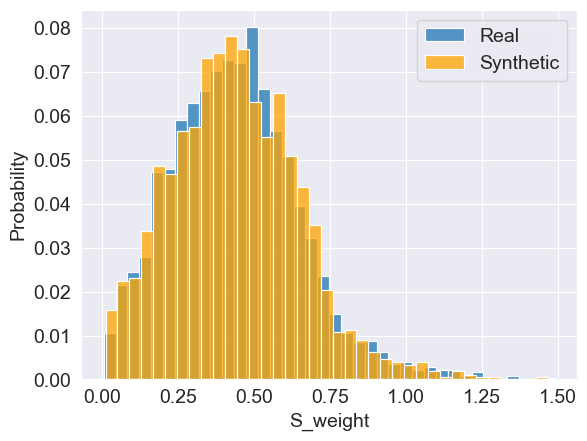

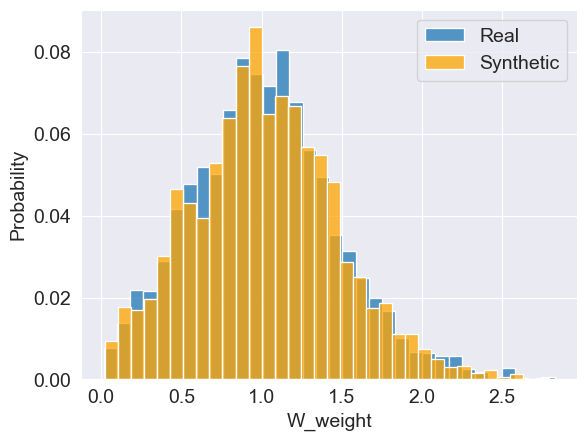

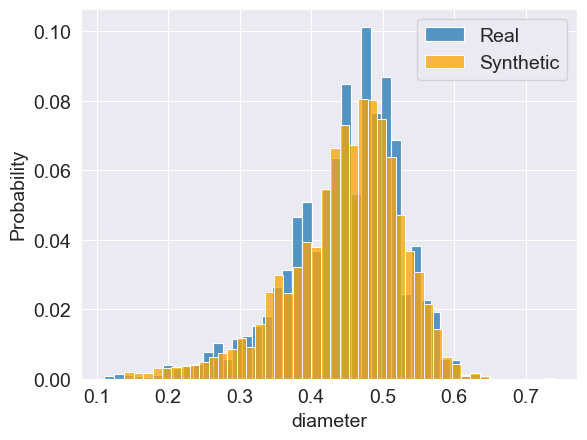

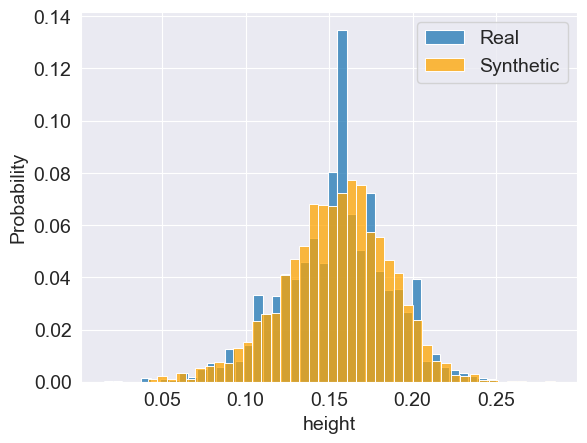

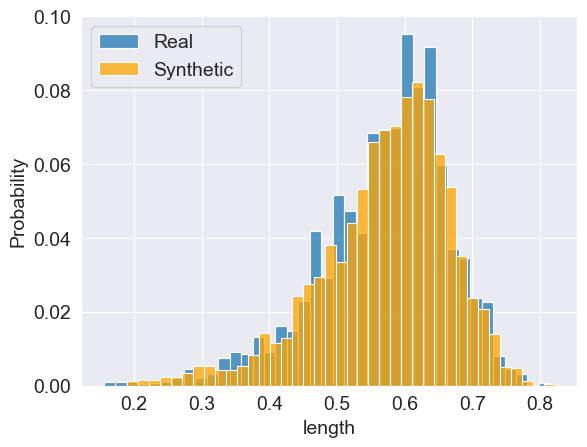

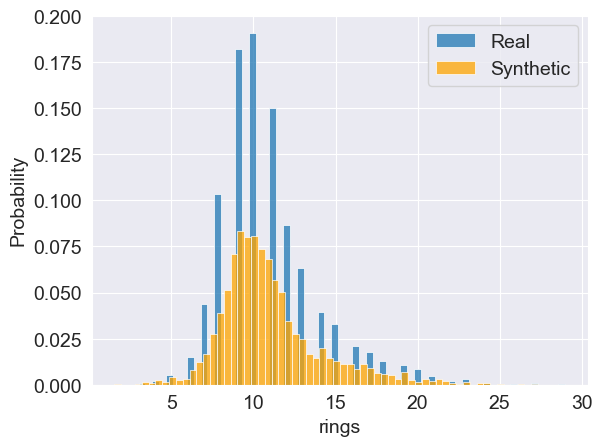

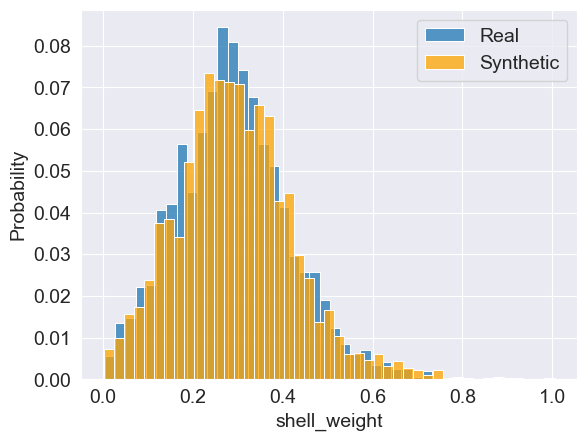

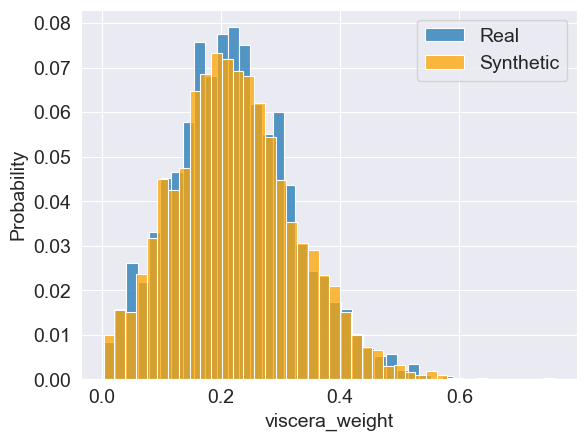

In [56]:
data_c = data_errors.copy()
data_c["type"] = "Real"
synthetic["type"] = "Synthetic"
all_data = pd.concat([data_c, synthetic])
for feat in features:
    plt.figure()
    for g, color in zip(["Real", "Synthetic"], [None, "orange"]):
        sns.histplot(all_data[all_data["type"]==g], x=feat, label=g, color=color, stat = 'probability')
        plt.legend()

# Высокая ошибка
Закладываем ошибку на уровне 0.7

In [16]:
n

2835

In [17]:
HEdata = cbn.sample(int(n*0.2), evidence={"inconf_error": 0.7})[data_errors.columns]

100%|██████████| 567/567 [00:09<00:00, 62.44it/s]


In [18]:
HEdata.columns

Index(['sex', 'length', 'diameter', 'height', 'W_weight', 'S_weight',
       'viscera_weight', 'shell_weight', 'rings', 'inconf_error'],
      dtype='object')

In [19]:
from copy import copy
from sklearn.metrics import log_loss, roc_auc_score
def inconfidence_score(y_true, y_pred):
    return np.mean((1 - y_pred) * y_true + y_pred * (1 - y_true))

def inconfidence_score_ew(y_true, y_pred):
    return (1 - y_pred) * y_true + y_pred * (1 - y_true)

In [39]:
pipeline_data["cont_features"]

['length',
 'diameter',
 'height',
 'W_weight',
 'S_weight',
 'viscera_weight',
 'shell_weight',
 'rings',
 'inconf_error']

In [38]:
np.where(pipeline_data["cont_features"]=='inconf_error')

(array([], dtype=int64),)

In [40]:
pipeline_data["cont_features_edges"][-1]

array([0.08880842, 0.3580721 , 0.49315873, 0.89158182])

In [62]:
def implied_error_experiment(nruns, error_grad_limits, k):
    fracs = list()
    lims = error_grad_limits
    for _ in range(nruns):
        med = data_errors[(data_errors['inconf_error'] >= lims[k])&(data_errors['inconf_error'] < lims[k+1])]['inconf_error'].median()
        HEdata = cbn.sample(int(n*0.2), evidence={"inconf_error": med}, progress_bar=False)[data_errors.columns]
        HEpred = model.predict_proba(HEdata[features])[:, 1]
        errors = inconfidence_score_ew(HEdata[target].astype(int), HEpred)
        error = inconfidence_score(HEdata[target].astype(int), HEpred)
    
        fracs.append(np.mean((errors>=lims[k])&(errors<lims[k+1])))
    return fracs

In [63]:
np.random.seed(42)
low_frac = implied_error_experiment(50, pipeline_data["cont_features_edges"][-1], 0)
np.random.seed(42)
high_frac = implied_error_experiment(50, pipeline_data["cont_features_edges"][-1], 2)

In [86]:
pd.DataFrame(data=[low_frac, high_frac], index=['low_frac', 'high_frac']).transpose().to_csv('classif_abalone_synth.csv')

In [20]:
HEdata[target]

0      0
1      1
2      1
3      1
4      1
      ..
557    0
558    0
559    1
560    0
561    1
Name: sex, Length: 562, dtype: object

In [57]:
lims = pipeline_data["cont_features_edges"][-1]
med = data_errors[(data_errors['inconf_error'] >= lims[0])&(data_errors['inconf_error'] < lims[1])]['inconf_error'].mean()
med

0.26809323999415147

In [21]:

HEpred = model.predict_proba(HEdata[features])[:, 1]
errors = inconfidence_score_ew(HEdata[target].astype(int), HEpred)
error = inconfidence_score(HEdata[target].astype(int), HEpred)
errors

0      0.630043
1      0.677105
2      0.654444
3      0.379837
4      0.891582
         ...   
557    0.553548
558    0.637487
559    0.632188
560    0.576913
561    0.904768
Name: sex, Length: 562, dtype: float64

In [22]:
error

0.6354338000248146

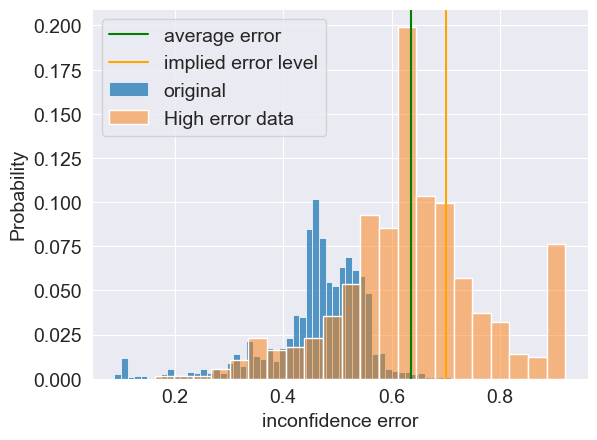

In [23]:
sns.histplot(data_errors["inconf_error"], label="original", stat = 'probability')
sns.histplot(errors, label="High error data", alpha=0.5, stat = 'probability')
plt.axvline(error, label="average error", color="g")
plt.axvline(0.7, label="implied error level", color="orange")
plt.xlabel("inconfidence error")
plt.legend()

In [25]:
#all metrics before and after enrichment
for metric in [inconfidence_score, log_loss, roc_auc_score]:
    bef = metric(data[target].astype(int), probs)
    aft = metric(HEdata[target].astype(int), HEpred)
    print(f"Before {bef: .3f} , after {aft: .3f}")

Before  0.462 , after  0.635
Before  0.633 , after  1.098
Before  0.718 , after  0.065


In [82]:
def enrichen_experiment(nruns, error_grad_limits, k, frac):
    diffs = list()
    ndecrease, nincrease = list(), list()
    lims = error_grad_limits
    before = inconfidence_score_ew(data[target].astype(int), model.predict_proba(data[features])[:, 1])
    for _ in range(nruns):
        med = data_errors[(data_errors['inconf_error'] >= lims[k])&(data_errors['inconf_error'] < lims[k+1])]['inconf_error'].median()
        HEdata = cbn.sample(int(n*frac), evidence={"inconf_error": med}, progress_bar=False)[data_errors.columns]
        #HEpred = model.predict_proba(HEdata[features])[:, 1]
        enriched_data = pd.concat([data, HEdata[features + [target]]])
        enriched_data[target] = enriched_data[target].astype(int)
        model1 = copy(model)
        model1.fit(enriched_data[features], enriched_data[target])
        predEN = model1.predict_proba(data[features])[:, 1]
        errorse = inconfidence_score_ew(data[target].astype(int), predEN)
        errore = inconfidence_score(data[target].astype(int), predEN)
        
        ndecrease.append(np.mean((errorse-before)<0))
        nincrease.append(np.mean((errorse-before)>=0))
        diffs.append(np.mean(errorse-before))
    return diffs, ndecrease, nincrease

In [83]:
lists = {'he':[[], [], []], 'le':[[], [], []]}
for frac in [0.2, 0.4, 0.6, 0.8]:
    np.random.seed(42)
    low_error, ledec, leinc = enrichen_experiment(50, pipeline_data["cont_features_edges"][-1], 0, frac)
    np.random.seed(42)
    high_error, hedec, heinc = enrichen_experiment(50, pipeline_data["cont_features_edges"][-1], 2, frac)
    
    for k, e in enumerate([low_error, ledec, leinc]):
        lists['le'][k].append(e)
    for k, e in enumerate([high_error, hedec, heinc]):
        lists['he'][k].append(e)

In [ ]:
means = {'he': [], 'le': []}
for i in range(3):
    for k in range(4):
        means['he'].

In [89]:
[sum(lists['he'][1][k])/50 for k in range(4)]

[0.4643416872573244,
 0.45747970349452866,
 0.4541616660783622,
 0.450363572184963]

In [91]:
[sum(lists['he'][2][k])/50 for k in range(4)]

[0.5356583127426756, 0.5425202965054714, 0.5458383339216377, 0.549636427815037]

In [90]:
[sum(lists['le'][1][k])/50 for k in range(4)]

[0.4962442640310624,
 0.49068831627250264,
 0.48732086127779745,
 0.48920578891634314]

In [92]:
[sum(lists['le'][2][k])/50 for k in range(4)]

[0.5037557359689376,
 0.5093116837274975,
 0.5126791387222026,
 0.5107942110836569]

In [87]:
import scipy.stats as st

In [96]:
st.t.interval(0.9, df=49, loc=np.mean(lists['le'][1][0]), scale=st.sem(lists['le'][1][0]))

(0.49352627023654505, 0.4989622578255799)

In [105]:
means1 = [sum(lists['le'][1][k])/50 for k in range(4)]
left1 = [st.t.interval(0.95, df=49, loc=np.mean(lists['le'][1][k]), scale=st.sem(lists['le'][1][k]))[0] for k in range(4)]
right1 = [st.t.interval(0.95, df=49, loc=np.mean(lists['le'][1][k]), scale=st.sem(lists['le'][1][k]))[1] for k in range(4)]

In [99]:
means1, left1

([0.4962442640310624,
  0.49068831627250264,
  0.48732086127779745,
  0.48920578891634314],
 [0.49352627023654505,
  0.48837757407114923,
  0.48539292797864464,
  0.48734142652326384])

Text(0, 0.5, 'Fraction of decreases')

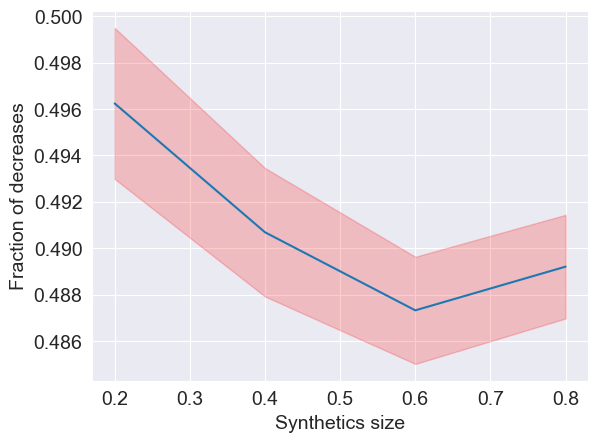

In [107]:
plt.plot([0.2, 0.4, 0.6, 0.8], means1)
plt.fill_between([0.2, 0.4, 0.6, 0.8], left1, right1, color='red', alpha=0.2)
plt.xlabel("Synthetics size")
plt.ylabel("Fraction of decreases")

In [108]:
means1 = [sum(lists['he'][2][k])/50 for k in range(4)]
left1 = [st.t.interval(0.95, df=49, loc=np.mean(lists['he'][2][k]), scale=st.sem(lists['he'][2][k]))[0] for k in range(4)]
right1 = [st.t.interval(0.95, df=49, loc=np.mean(lists['he'][2][k]), scale=st.sem(lists['he'][2][k]))[1] for k in range(4)]

Text(0, 0.5, 'Fraction of decreases')

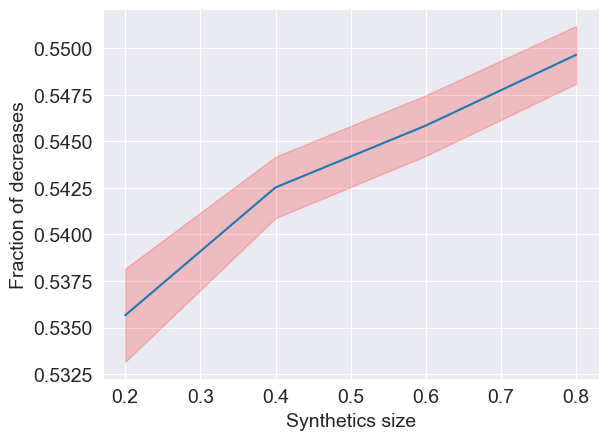

In [109]:
plt.plot([0.2, 0.4, 0.6, 0.8], means1)
plt.fill_between([0.2, 0.4, 0.6, 0.8], left1, right1, color='red', alpha=0.2)
plt.xlabel("Synthetics size")
plt.ylabel("Fraction of decreases")

In [88]:
len(lists['he'][0])

4

In [74]:
ledec, leinc

([0.48676314860571834,
  0.48182139075185315,
  0.5026473702788563,
  0.49876456053653373,
  0.5090010589481115,
  0.4948817507942111,
  0.49876456053653373,
  0.508648076244264,
  0.4931168372749735,
  0.48499823508648077,
  0.4895870102364984,
  0.49452876809036356,
  0.4955877162019061,
  0.49099894105188846,
  0.4959406989057536,
  0.5022943875750088,
  0.5022943875750088,
  0.47582068478644546,
  0.4952347334980586,
  0.4977056124249912,
  0.48535121779032825,
  0.5019414048711613,
  0.5075891281327215,
  0.5266501941404871,
  0.46558418637486765,
  0.4917049064595835,
  0.49699964701729615,
  0.4955877162019061,
  0.4977056124249912,
  0.47476173667490296,
  0.5090010589481115,
  0.49346981997882106,
  0.5058242146134839,
  0.5019414048711613,
  0.4871161313095658,
  0.47158489234027534,
  0.4701729615248853,
  0.5030003529827038,
  0.49029297564419344,
  0.4952347334980586,
  0.4948817507942111,
  0.4839392869749382,
  0.5114719378750441,
  0.4832333215672432,
  0.49982350864807

In [75]:
hedec, heinc

([0.45993646311330744,
  0.4641722555594776,
  0.45075891281327213,
  0.47758559830568303,
  0.4592304977056124,
  0.4567596187786798,
  0.45146487822096715,
  0.4592304977056124,
  0.4567596187786798,
  0.476173667490293,
  0.4669961171902577,
  0.45040593010942465,
  0.45111189551711967,
  0.4652312036710201,
  0.45393575714789974,
  0.46911401341334275,
  0.45640663607483234,
  0.46911401341334275,
  0.48358630427109073,
  0.4578185668902224,
  0.45111189551711967,
  0.460289445817155,
  0.4737027885633604,
  0.47158489234027534,
  0.4461701376632545,
  0.4532297917402047,
  0.4482880338863396,
  0.44722908577479703,
  0.4592304977056124,
  0.4641722555594776,
  0.4613483939286975,
  0.47334980585951286,
  0.45075891281327213,
  0.47935051182492056,
  0.45746558418637484,
  0.4620543593363925,
  0.475467702082598,
  0.4677020825979527,
  0.4581715495940699,
  0.4684080480056477,
  0.45887751500176494,
  0.44793505118249205,
  0.48252735615954817,
  0.47158489234027534,
  0.473349805

In [71]:
low_error

[0.0012102434523492485,
 0.0015630685575646341,
 0.00033842123287102394,
 0.0014864130972101826,
 -0.0007405190897712495,
 0.00041591079630469587,
 0.0016485896559092108,
 -0.000504342077555945,
 0.0009497357568841502,
 0.0013885671159355158,
 0.0018562914262333285,
 0.0015771609256893969,
 0.001617340839887545,
 0.0011326147023145712,
 5.4719927644274366e-05,
 -8.030302743157716e-05,
 -0.0003860961276066927,
 0.0036448290382190326,
 0.0012062348444010166,
 -0.0004322099252751304,
 0.0012068850007425952,
 0.0006686665940059375,
 -0.00031610287529287157,
 -0.00206599945295701,
 0.001520920068663713,
 0.0019375200599861166,
 -0.00030747188123916684,
 0.0005116319382505061,
 0.0008902957569372282,
 0.002035904407245434,
 -0.0010527129020283835,
 0.0004350853343100731,
 -0.0002759288806732676,
 -0.0003480424853702904,
 0.002256662761587212,
 0.0009177489740154107,
 0.0023078678260588306,
 0.0016168761540613415,
 0.00010465571914371504,
 0.0005512426883236736,
 0.0006913915694134219,
 0.000

In [68]:
high_error

[0.005493545966137275,
 0.005760444676972412,
 0.006119987560771578,
 0.006364145874094212,
 0.006907361236978781,
 0.006037036986295481,
 0.005854890953991225,
 0.005361821855508599,
 0.006463753310976194,
 0.006414968189788512,
 0.004607203317560227,
 0.007131808850305277,
 0.007098429828352207,
 0.006181605814639647,
 0.005975978478403218,
 0.006385076652166882,
 0.006432463332452936,
 0.00583049676693816,
 0.0077382058718638265,
 0.005314898905479864,
 0.006947622646075849,
 0.006941083221197354,
 0.005645917376070676,
 0.005773325881562942,
 0.005524303998176331,
 0.007432252155718524,
 0.005786157243362244,
 0.0073696586224078695,
 0.006585343924084674,
 0.006203471574781858,
 0.007445302761739675,
 0.006837923175205149,
 0.006670875144602598,
 0.007132026940534549,
 0.0076879839547596696,
 0.0058674206887754455,
 0.004409845970287059,
 0.006277862626220959,
 0.007195174094820242,
 0.006152459104749229,
 0.006168191627914237,
 0.007299872301838134,
 0.006954949829354812,
 0.00702

In [26]:
enriched_data = pd.concat([data, HEdata[features + [target]]])
enriched_data[target] = enriched_data[target].astype(int)
model1 = copy(model)
model1.fit(enriched_data[features], enriched_data[target])


GradientBoostingClassifier(n_estimators=50)

In [27]:
predEN = model1.predict_proba(enriched_data[features])[:, 1]

In [28]:
errorse = inconfidence_score_ew(enriched_data[target].astype(int), predEN)
errore = inconfidence_score(enriched_data[target].astype(int), predEN)
errorse

0      0.356838
1      0.456604
2      0.545735
3      0.477780
4      0.518756
         ...   
557    0.094405
558    0.171349
559    0.120805
560    0.104846
561    0.196883
Name: sex, Length: 3395, dtype: float64

In [29]:

current_error, errore

(0.4614116561413063, 0.43331184802324685)

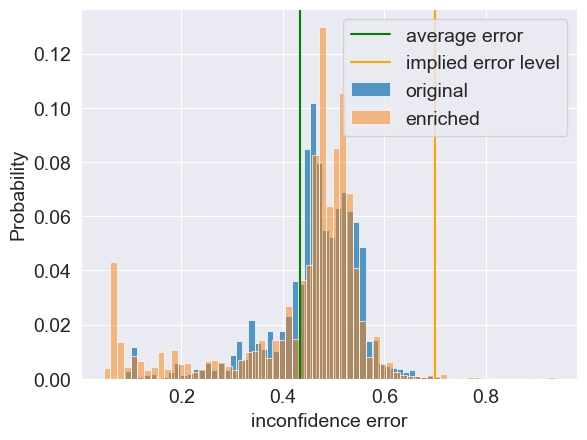

In [30]:
sns.histplot(data_errors["inconf_error"], label="original", stat = 'probability')
sns.histplot(errorse, label="enriched", alpha=0.5, stat = 'probability')
plt.axvline(errore, label="average error", color="g")
plt.axvline(0.7, label="implied error level", color="orange")
plt.xlabel("inconfidence error")
plt.legend()

In [31]:
#all metrics before and after enrichment
for metric in [inconfidence_score, log_loss, roc_auc_score]:
    bef = metric(data[target], probs)
    aft = metric(enriched_data[target], predEN)
    print(f"Before {bef: .3f} , after {aft: .3f}")

Before  0.462 , after  0.433
Before  0.633 , after  0.595
Before  0.718 , after  0.745


# Низкая ошибка
Закладываем ошибку на уровне 0.1

In [32]:
LEdata = cbn.sample(int(n*0.2), evidence={"inconf_error": 0.1})[data_errors.columns]

100%|██████████| 567/567 [00:08<00:00, 63.56it/s]


In [33]:

LEpred = model.predict_proba(LEdata[features])[:, 1]
errors_l = inconfidence_score_ew(LEdata[target].astype(int), LEpred)
error_l = inconfidence_score(LEdata[target].astype(int), LEpred)
errors_l

0      0.216471
1      0.095640
2      0.102502
3      0.100054
4      0.108418
         ...   
561    0.097105
562    0.156676
563    0.108418
564    0.546082
565    0.102502
Name: sex, Length: 566, dtype: float64

In [34]:
error_l

0.32207666988538086

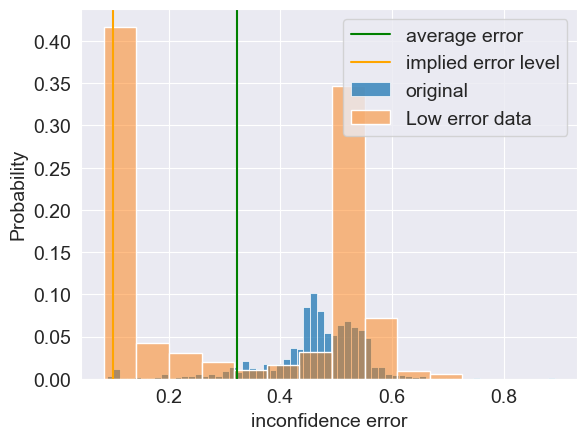

In [35]:
sns.histplot(data_errors["inconf_error"], label="original", stat = 'probability')
sns.histplot(errors_l, label="Low error data", alpha=0.5, stat = 'probability')
plt.axvline(error_l, label="average error", color="g")
plt.axvline(0.1, label="implied error level", color="orange")
plt.xlabel("inconfidence error")
plt.legend()

In [36]:
#all metrics before and after enrichment
for metric in [inconfidence_score, log_loss, roc_auc_score]:
    bef = metric(data[target].astype(int), probs)
    aft = metric(LEdata[target].astype(int), LEpred)
    print(f"Before {bef: .3f} , after {aft: .3f}")

Before  0.462 , after  0.322
Before  0.633 , after  0.439
Before  0.718 , after  0.996


In [74]:
enriched_data_l = pd.concat([data, LEdata[features + [target]]])
enriched_data_l[target] = enriched_data_l[target].astype(int)
model2 = copy(model)
model2.fit(enriched_data_l[features], enriched_data_l[target])


GradientBoostingClassifier(n_estimators=50)

In [75]:
predENL = model2.predict_proba(enriched_data_l[features])[:, 1]

In [76]:
errorsel = inconfidence_score_ew(enriched_data_l[target].astype(int), predENL)
errorel = inconfidence_score(enriched_data_l[target].astype(int), predENL)
errorsel

0       0.307605
1       0.233646
2       0.452116
3       0.471949
4       0.422865
          ...   
2965    0.016599
2966    0.015340
2967    0.014845
2968    0.015340
2969    0.035482
Name: sex, Length: 5803, dtype: float64

In [78]:
current_error, errorel

(0.4612121475189436, 0.24672513168541427)

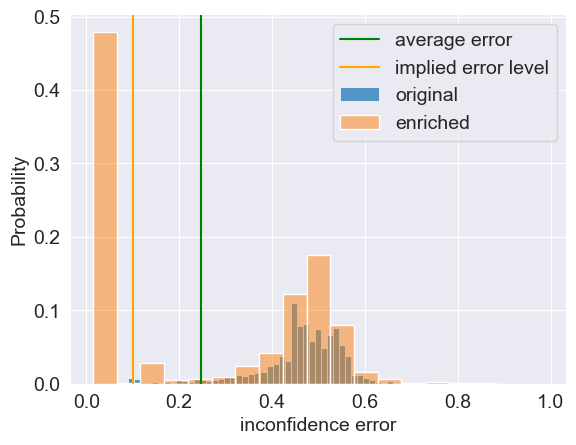

In [80]:
sns.histplot(data_errors["inconf_error"], label="original", stat = 'probability')
sns.histplot(errorsel, label="enriched", alpha=0.5, stat = 'probability')
plt.axvline(errorel, label="average error", color="g")
plt.axvline(0.1, label="implied error level", color="orange")
plt.xlabel("inconfidence error")
plt.legend()

In [82]:
#all metrics before and after enrichment
for metric in [inconfidence_score, log_loss, roc_auc_score]:
    bef = metric(data[target], probs)
    aft = metric(enriched_data_l[target], predENL)
    print(f"Before {bef: .3f} , after {aft: .3f}")

Before  0.462 , after  0.247
Before  0.633 , after  0.338
Before  0.714 , after  0.919


In [ ]:
bn.predict(pd.DataFrame(disc_data[disc_data["inconf_error"]==2]["inconf_error"]))

In [ ]:
data_errors

In [ ]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)
for e in cpds:
    if len(e.variables) == 1: # либо узел без родителей, либо изолированный узел
        feat = e.variables[0]
        if not any([(feat in edge) for edge in bn.edges]):
            continue
    pgmpy_bn.add_cpds(e)

In [ ]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 0}, nbars=10)

In [ ]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 1}, nbars=10)

In [ ]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 2}, nbars=10)

трактуем так: вероятность того, что ошибка регрессии будет высокой, наиболее чувствительна к изменению параметра, отвечающего за условную вероятность ошибки быть высокой при условии высокого УФ-индекса (здесь 1 маскимальный) и среднего давления

In [ ]:
current_error

In [ ]:
from copy import copy

# BicScore boosting: diameter = High, shell_weight = Mid
# K2Score boosting: нет рекомендаций
# logreg: [S_weight, diameter, rings, shell_weight, viscera_weight] = [0, 1, 0, 0, 0]

In [ ]:
from sklearn.metrics import log_loss
from random import choices

In [ ]:
def inconfidence_score(y_true, y_pred):
    return np.mean((1-y_pred)*y_true + y_pred*(1-y_true))

In [ ]:
dfeat = ["length", "shell_weight"]
dcat = [2, 1]
#dfeat = ["diameter"]
#dcat = [1]
bootn = n
def bootstrap_sampling(dfeat, dcat, trials=1000, alpha=0):
    
    diffs = list()
    mses_before, mses_after = list(), list()
    n_dropped = list()
    
    #пробуем побутсрапировать выборку, чтобы оценить значимость различий в ошибках регрессии
    for i in tqdm(range(trials)):
        indexes = np.random.randint(n, size=bootn)
        bsample = data.iloc[indexes]
        
        bsample_disc = pd.DataFrame(pipeline_data["transformer"].transform(bsample), columns=features+[target])
        
        mask = False
        for feat, cat in zip(dfeat, dcat):
            mask = mask | (bsample_disc[feat]==cat)
        
        X1, y1 = bsample[features], bsample[target]
        model1, model2 = copy(model), copy(model)
        model1.fit(X1, y1)
        y1_pred = model1.predict(X1)
        indexes_to_drop = np.random.choice(bsample[mask].index, size=int(np.floor(bsample[mask].shape[0]*(1-alpha))), replace=False)
        
        new_bsample = bsample.drop(index=indexes_to_drop)
        
        X2, y2 = new_bsample[features], new_bsample[target]
        
        model2.fit(X2, y2)
        
        y2_pred = model2.predict(X2)
        mses_before.append(inconfidence_score(y1, y1_pred))
        mses_after.append(inconfidence_score(y2, y2_pred))
        diffs.append(inconfidence_score(y1, y1_pred) - inconfidence_score(y2, y2_pred))
        n_dropped.append(indexes_to_drop.shape[0])
        
    return mses_before, mses_after, diffs, sum(n_dropped)/trials

In [ ]:
data.shape

In [ ]:
np.random.seed(42)
mses_before, mses_after, diffs = bootstrap_sampling(dfeat, dcat, trials=500)

In [ ]:
percentage_changes = list()
mean_differences = list()
alphas = np.linspace(0, 1, 11)
for a in alphas[:-1]:
    np.random.seed(42)
    mses_before, mses_after, diffs, _ = bootstrap_sampling(dfeat, dcat, trials=500, alpha=a)
    if a == 0:
        print(_)
    x, y = np.array(mses_before), np.array(mses_after)
    mean_differences.append((x-y).mean())
    percentage_changes.append(((y-x)/x).mean()*100)
percentage_changes.append(0)
mean_differences.append(0)

In [ ]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [ ]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [ ]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [ ]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [ ]:
from scipy.stats import ttest_rel

In [ ]:
ttest_rel(mses_before, mses_after)

In [ ]:
ttest_rel(mses_before, mses_after)

In [ ]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

In [ ]:
from itertools import product

In [ ]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "sq_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "sq_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

In [ ]:
gbn.get_info()


# k2score boosting: нет рекомендаций
# regression : [Tsurf_mean_0, pressure_2]

In [ ]:
dfeat = ["S_weight", "shell_weight"]
dcat = [0, 0]
np.random.seed(42)
mses_before, mses_after, diffs = bootstrap_sampling(dfeat, dcat, trials=500)

In [ ]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [ ]:
ttest_rel(mses_before, mses_after)

In [ ]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [ ]:
ttest_rel(mses_before, mses_after)

In [ ]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [ ]:
ttest_rel(mses_before, mses_after)

In [ ]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_onehot = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')

In [ ]:
disc_data_onehot

In [ ]:
gbn = DiscreteBNGI(imagespath)

In [ ]:
variables=["X1", "X2"]
#gbn.add_nodes(kresult["bn"].descriptor)
#grads = [feat+'_'+str(k) for feat in variables for k in range(n_states_map[feat])]
grads = [feat+'_'+str(k) for feat in variables for k in range(3)]
gbn.add_nodes({"types": {feat: "disc" for feat in grads}})
#gbn.set_edges(grad_edges)
gbn.add_edges(data=disc_data_onehot, scoring_function=("K2", K2Score))

In [ ]:
c=gbn.plot("regression.html")

In [ ]:
disc_data_errors, pipeline_data_errors = discretize(data_errors, variables=data_errors.columns.tolist(), icat=None, icont=[0, 1])

In [ ]:
disc_data_errors

In [ ]:
kresultresid = construct_by_kmeans(data_residuals, [], scoring=("K2", K2Score))

In [ ]:
c=kresultresid["bn"].plot2(imagespath, "residuals.html")